# Libraries

In [6]:
!pip install networkx numpy scikit-learn torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.7 MB/s eta 0:00:00


# Dataset

Unzip df_data.zip and embeddings.npy.zip

In [3]:
import pandas as pd
df_data = pd.read_pickle("df_data.pkl")
df_data

,Date,Publication,Headline,URL,result,is_climate_related,severity,explanation,topic,keywords,...,risk_matrix.severity_level,risk_matrix.justification,taxonomy.dimension,taxonomy.hazards,taxonomy.sectors,taxonomy.policy_areas,taxonomy.actors,taxonomy.timescale,embedding,likelihood
0,20070101,Daily Mail,Here it is! Winds of up to 105mph as gigantic ...,http://www.dailymail.co.uk/news/worldnews/arti...,"{'is_climate_related': True, 'severity': 'high...",True,high,The headline describes a hurricane with extrem...,Hurricane impact,"[hurricane, extreme winds, east coast, storm, ...",...,5,The headline describes a high-intensity hurric...,health,[hurricane],"[infrastructure, public safety]",[disaster response],"[local government, residents]",acute,"[-0.044163413, 0.027461544, -0.01045467, 0.006...",medium
1,20070101,Daily Mail,Fears that 110mph Hurricane Earl could sideswi...,http://www.dailymail.co.uk/news/worldnews/arti...,"{'is_climate_related': True, 'severity': 'high...",True,high,"The headline directly references a hurricane, ...",Hurricane threat to northeastern US,"[hurricane, extreme weather, new york, boston,...",...,4,High wind speeds (110mph) and potential impact...,health,[hurricane],[emergency_management],[disaster_preparedness],[local_government],acute,"[-0.04741198, 0.04578507, -0.02556545, 0.03635...",medium
2,20070106,New York Times,Editorial: Global Warming,http://www.nytimes.com/2007/01/06/opinion/06sa...,"{'is_climate_related': True, 'severity': 'high...",True,high,The headline directly mentions 'Global Warming...,Global Warming,"[global warming, climate change]",...,5,"Global warming is a high-probability, high-sev...",health,[global warming],[],[],[],chronic,"[0.034963317, 0.046056915, 0.014969153, 0.0053...",high
3,20070115,New York Times,The Basics: Connecting the Global Warming Dots,http://www.nytimes.com/2007/01/14/weekinreview...,"{'is_climate_related': True, 'severity': 'medi...",True,medium,The headline directly mentions 'global warming...,global warming awareness,"[global warming, climate change, climate aware...",...,3,Global warming is a significant climate issue ...,health,[global warming],[],[],[],None,"[0.015842758, 0.04761041, 0.00043560145, 0.043...",medium
4,20070116,CNBC,GE Forms Partnership on Greenhouse Gases,http://www.cnbc.com/id/16658733,"{'is_climate_related': True, 'severity': 'medi...",True,medium,"The headline mentions 'Greenhouse Gases', whic...",Corporate partnership on greenhouse gases,"[greenhouse gases, partnership, emissions, cli...",...,3,Corporate partnerships on greenhouse gases can...,policy,[],[corporate],[emissions reduction],[corporations],None,"[0.019784681, 0.041939758, 0.008853864, 0.0313...",medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14057,20221230,The Guardian,How ocean wind power could help the US fossil ...,https://www.theguardian.com/environment/2022/d...,"{'is_climate_related': True, 'severity': 'medi...",True,medium,"The headline discusses ocean wind power, a ren...",Renewable energy transition,"[ocean wind power, renewable energy, fossil fu...",...,3,The headline suggests a significant but not im...,social,[],[energy],[renewable energy policy],[fossil fuel industry],multi-year,"[-0.009818218, 0.09619677, -0.01872475, -0.003...",high
14058,20221231,New York Times,"Stephen Lam/San Francisco Chronicle, via Assoc...",https://www.nytimes.com/2022/12/31/us/californ...,"{'is_climate_related': True, 'severity': 'medi...",True,medium,The headline describes extreme weather events ...,Extreme weather in California,"[heavy rain, flooding, drought, atmospheric ri...",...,3,The headline describes significant weather eve...,health,"[flooding, heavy rain, atmospheric river]",[water resources],[],[],acute,"[-0.03473906, 0.029183319, -0.01769299, 0.0170...",high
14059,20221231,FOX,"Heavy rain forces widespread road closures, ev...",https://www.foxnews.com/us/heavy-rain-slams-ce...,"{'is_climate_related': True, 'severity': 'medi.

# Source Code: Link Prediction and Node Classification

In [8]:
#@title Data reconstruction from GNN Link Prediction e Node Classification
import os, pickle, random
from typing import Tuple, List, Dict, Union, Any

import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, precision_recall_fscore_support, accuracy_score,
    balanced_accuracy_score, f1_score
)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

# -----------------------------
# Matplotlib:
# -----------------------------
mpl.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.0,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})

# ============
# Utilidades
# ============
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def load_graph(graph_path: str) -> nx.Graph:
    with open(graph_path, "rb") as f:
        G = pickle.load(f)
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()
    if not nx.is_connected(G):
        cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(cc).copy()
        print(f"[AVISO] Grafo não conexo. Usando maior componente: {G.number_of_nodes()} nós, {G.number_of_edges()} arestas.")
    return G

def load_embeddings(emb_src: Union[str, np.ndarray], G: nx.Graph) -> Tuple[np.ndarray, Dict]:
    if isinstance(emb_src, str):
        X = np.load(emb_src)
    elif isinstance(emb_src, np.ndarray):
        X = emb_src
    else:
        raise ValueError("emb_src deve ser caminho .npy ou np.ndarray.")
    nodes = list(G.nodes()); n = len(nodes)

    # Caso simples: nós 0..N-1
    if X.shape[0] == n and set(nodes) == set(range(n)):
        return X.astype(np.float32), {i: i for i in nodes}

    # Atributo 'feat_idx'
    if all('feat_idx' in G.nodes[u] for u in nodes):
        idxs = [G.nodes[u]['feat_idx'] for u in nodes]
        if max(idxs) < X.shape[0]:
            Xo = X[idxs]
            return Xo.astype(np.float32), {u: i for i, u in enumerate(nodes)}

    # Fallback: X ordenado por sorted(G.nodes())
    sorted_nodes = sorted(nodes)
    if X.shape[0] != n:
        raise ValueError(f"X.shape[0] ({X.shape[0]}) != #nós ({n}). Ajuste alinhamento.")
    node_to_idx_sorted = {u: i for i, u in enumerate(sorted_nodes)}
    perm = [node_to_idx_sorted[u] for u in nodes]
    Xo = X[perm]
    return Xo.astype(np.float32), {u: i for i, u in enumerate(nodes)}

def edges_tensor_from_graph(G: nx.Graph, node_to_idx: Dict) -> torch.Tensor:
    edges = []
    for u, v in G.edges():
        a, b = node_to_idx[u], node_to_idx[v]
        edges.append([a, b]); edges.append([b, a])  # não-direcionado explícito
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

def remove_edges_keep_connected(G: nx.Graph, pct_remove: float, seed: int = 42) -> Tuple[nx.Graph, List[Tuple]]:
    """Remove apenas arestas que NÃO são pontes (bridges), recalculando iterativamente."""
    assert 0 < pct_remove < 1
    set_seed(seed)
    rng = random.Random(seed)
    Gw = G.copy()
    target = int(round(Gw.number_of_edges() * pct_remove))
    removed: List[Tuple] = []
    while len(removed) < target:
        bridges = set(nx.bridges(Gw))
        candidates = [e for e in Gw.edges() if e not in bridges and (e[1], e[0]) not in bridges]
        if not candidates:
            break
        rng.shuffle(candidates)
        for u, v in candidates:
            if len(removed) >= target: break
            if Gw.has_edge(u, v):
                Gw.remove_edge(u, v)  # por definição não desconecta
                removed.append((u, v))
    if len(removed) < target:
        print(f"[AVISO] Removidas {len(removed)}/{target} sem desconectar (faltaram não-bridges).")
    return Gw, removed

def sample_negative_edges(num_nodes: int, existing_edges_set: set, num_samples: int, seed: int = 42) -> np.ndarray:
    """Amostra pares (i<j) sem aresta; evita (a,b) existentes."""
    set_seed(seed)
    neg = []; attempts, max_attempts = 0, num_samples * 50 + 10000
    while len(neg) < num_samples and attempts < max_attempts:
        i = random.randrange(num_nodes); j = random.randrange(num_nodes)
        if i == j: attempts += 1; continue
        a, b = (i, j) if i < j else (j, i)
        if (a, b) not in existing_edges_set and (b, a) not in existing_edges_set:
            neg.append((a, b))
        attempts += 1
    if len(neg) < num_samples:
        print(f"[AVISO] Negativos amostrados: {len(neg)}/{num_samples}.")
    return np.array(neg, dtype=np.int64)

# ==========================
# (A) Predição de Links
# ==========================
class GNNEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 64, out_dim: int = 64):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, out_dim)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index); h = F.relu(h)
        h = self.conv2(h, edge_index)
        return h

def decode_dot(z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
    s, t = edge_index
    return (z[s] * z[t]).sum(dim=-1)

def train_link_pred(
    x: torch.Tensor, edge_index: torch.Tensor,
    hidden: int = 64, out_dim: int = 64,
    epochs: int = 200, lr: float = 1e-3,
    device: str = None, verbose: bool = True
) -> Tuple[GNNEncoder, torch.Tensor]:
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    x, edge_index = x.to(device), edge_index.to(device)
    model = GNNEncoder(x.size(-1), hidden, out_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    num_nodes = x.size(0)

    for epoch in range(1, epochs+1):
        model.train(); opt.zero_grad()
        z = model(x, edge_index)
        e_np = edge_index.t().detach().cpu().numpy()
        pos_np = e_np[e_np[:,0] < e_np[:,1]]  # evita duplicados
        pos = torch.from_numpy(pos_np.T).long().to(device)
        neg = negative_sampling(edge_index=edge_index, num_nodes=num_nodes,
                                num_neg_samples=pos.size(1), method="sparse").to(device)
        logits = torch.cat([decode_dot(z, pos), decode_dot(z, neg)], dim=0)
        labels = torch.cat([torch.ones(pos.size(1), device=device),
                            torch.zeros(neg.size(1), device=device)], dim=0)
        loss = loss_fn(logits, labels)
        loss.backward(); opt.step()

        if verbose and (epoch % 20 == 0 or epoch == 1):
            with torch.no_grad():
                probs = torch.sigmoid(logits).detach().cpu().numpy()
                y = labels.detach().cpu().numpy()
                try:
                    print(f"[LinkPred] Epoch {epoch:03d} | Loss {loss.item():.4f} "
                          f"| AUROC {roc_auc_score(y, probs):.4f} | AP {average_precision_score(y, probs):.4f}")
                except Exception:
                    print(f"[LinkPred] Epoch {epoch:03d} | Loss {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        z = model(x, edge_index)
    return model, z.detach().cpu()

def evaluate_link_with_plots(
    z: torch.Tensor,
    test_pos_edges: List[Tuple[int,int]],
    train_edge_index: torch.Tensor,
    report_pdf_path: str = "linkpred_report.pdf",
    seed: int = 42,
    threshold: float = 0.5,
    optimize_threshold: str = None,  # None | "youden" | "f1"
    show_plots: bool = True
) -> Dict[str, Any]:
    set_seed(seed); device = z.device
    e_np = train_edge_index.t().detach().cpu().numpy()
    e_set = set((int(a), int(b)) if a < b else (int(b), int(a)) for a, b in e_np)

    pos_pairs = list(set((min(a,b), max(a,b)) for a,b in test_pos_edges))
    pos_idx = torch.tensor(pos_pairs, dtype=torch.long, device=device).t().contiguous()
    num_nodes = z.size(0)
    neg_np = sample_negative_edges(num_nodes, e_set, len(pos_pairs), seed=seed)
    neg_idx = torch.from_numpy(neg_np.T).long().to(device)

    pos_logits = decode_dot(z, pos_idx)
    neg_logits = decode_dot(z, neg_idx)
    logits = torch.cat([pos_logits, neg_logits], dim=0).detach().cpu().numpy()
    y_scores = 1/(1+np.exp(-logits))
    y_true = np.concatenate([np.ones(len(pos_pairs)), np.zeros(len(neg_np))]).astype(int)

    auroc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    thr_used = threshold
    if optimize_threshold == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_scores)
        idx = np.argmax(tpr - fpr); thr_used = float(thr[idx])
    elif optimize_threshold == "f1":
        grid = np.linspace(0.01, 0.99, 99); best_f1, best_thr = -1, threshold
        for t in grid:
            yb = (y_scores >= t).astype(int)
            f1p = f1_score(y_true, yb, average=None, labels=[0,1])[1] if (yb.sum()>0) else 0.0
            if f1p > best_f1: best_f1, best_thr = f1p, float(t)
        thr_used = best_thr

    y_pred = (y_scores >= thr_used).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = int(cm[0,0]), int(cm[0,1]), int(cm[1,0]), int(cm[1,1])

    prec, rec, f1, supp = precision_recall_fscore_support(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    cls0 = {"precision": float(prec[0]), "recall": float(rec[0]), "f1": float(f1[0]), "support": int(supp[0])}
    cls1 = {"precision": float(prec[1]), "recall": float(rec[1]), "f1": float(f1[1]), "support": int(supp[1])}
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = float(np.mean(f1))

    # --------- Figuras (PDF multipáginas) ----------
    with PdfPages(report_pdf_path) as pdf:
        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        fig1 = plt.figure(figsize=(6.4,5.0))
        plt.plot(fpr, tpr, label=f"ROC (AUROC={auroc:.3f})"); plt.plot([0,1],[0,1],"--", label="Random")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(loc="lower right")
        if show_plots: plt.show(); pdf.savefig(fig1, bbox_inches="tight"); plt.close(fig1)

        # PR
        pr_p, pr_r, _ = precision_recall_curve(y_true, y_scores)
        fig2 = plt.figure(figsize=(6.4,5.0))
        plt.plot(pr_r, pr_p, label=f"PR (AP={ap:.3f})")
        base = y_true.mean(); plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
        plt.xlabel("Recall (+)"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.legend(loc="lower left")
        if show_plots: plt.show(); pdf.savefig(fig2, bbox_inches="tight"); plt.close(fig2)

        # Distribuições de score
        fig3 = plt.figure(figsize=(6.4,5.0))
        plt.hist(y_scores[y_true==1], bins=40, alpha=0.6, density=True, label="Positives")
        plt.hist(y_scores[y_true==0], bins=40, alpha=0.6, density=True, label="Negatives")
        plt.axvline(thr_used, linestyle="--", label=f"Threshold={thr_used:.2f}")
        plt.xlabel("Predicted Probability"); plt.ylabel("Density"); plt.title("Score Distributions"); plt.legend()
        if show_plots: plt.show(); pdf.savefig(fig3, bbox_inches="tight"); plt.close(fig3)

        # Curvas vs limiar (precision/recall/F1 da classe positiva)
        grid = np.linspace(0.01, 0.99, 99); precs=[]; recs=[]; f1s=[]
        for t in grid:
            yb = (y_scores >= t).astype(int)
            p, r, f, _ = precision_recall_fscore_support(y_true, yb, labels=[0,1], average=None, zero_division=0)
            precs.append(p[1]); recs.append(r[1]); f1s.append(f[1])
        fig4 = plt.figure(figsize=(6.9,5.0))
        plt.plot(grid, precs, label="Precision (+)"); plt.plot(grid, recs, label="Recall (+)"); plt.plot(grid, f1s, label="F1 (+)")
        plt.axvline(thr_used, linestyle="--", label=f"Chosen Thr={thr_used:.2f}")
        plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Threshold vs Precision/Recall/F1"); plt.legend()
        if show_plots: plt.show(); pdf.savefig(fig4, bbox_inches="tight"); plt.close(fig4)

        # Matriz de confusão
        fig5 = plt.figure(figsize=(5.6,5.0))
        im = plt.imshow(cm, interpolation="nearest", cmap="Blues"); plt.title("Confusion Matrix"); plt.colorbar(im, fraction=0.046, pad=0.04)
        ticks = np.arange(2); plt.xticks(ticks, ["Pred 0","Pred 1"]); plt.yticks(ticks, ["True 0","True 1"])
        thresh = cm.max()/2 if cm.size>0 else 0
        for i in range(2):
            for j in range(2):
                plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center", color="white" if cm[i,j]>thresh else "black")
        plt.xlabel("Predicted"); plt.ylabel("True")
        if show_plots: plt.show(); pdf.savefig(fig5, bbox_inches="tight"); plt.close(fig5)

        # Calibração (binária)
        from sklearn.calibration import calibration_curve
        frac_pos, mean_pred = calibration_curve(y_true, y_scores, n_bins=10, strategy="uniform")
        fig6 = plt.figure(figsize=(6.4,5.0))
        plt.plot([0,1],[0,1],"--", label="Perfect"); plt.plot(mean_pred, frac_pos, marker="o", label="Model")
        plt.xlabel("Mean Predicted Probability"); plt.ylabel("Fraction of Positives"); plt.title("Calibration"); plt.legend()
        if show_plots: plt.show(); pdf.savefig(fig6, bbox_inches="tight"); plt.close(fig6)

    print("\n==== LINK PRED RESULTS ====")
    print(f"AUROC {auroc:.4f} | AP {ap:.4f} | Thr {thr_used:.2f}")
    print(f"CM -> TN:{tn} FP:{fp} FN:{fn} TP:{tp}")
    print("Class 0 (no-edge):", cls0)
    print("Class 1 (edge):   ", cls1)
    print("Overall:", {"accuracy": float(acc), "balanced_accuracy": float(bacc), "macro_f1": float(macro_f1)})
    print(f"[PDF salvo] {report_pdf_path}")

    return {
        "test_auroc": float(auroc), "test_ap": float(ap), "threshold_used": float(thr_used),
        "confusion_matrix": {"tn": tn, "fp": fp, "fn": fn, "tp": tp},
        "per_class": {"no_edge_0": cls0, "edge_1": cls1},
        "overall": {"accuracy": float(acc), "balanced_accuracy": float(bacc), "macro_f1": float(macro_f1)},
        "y_true": y_true, "y_scores": y_scores
    }

def run_link_prediction_with_plots(
    graph_path="graph.pkl", embeddings="embeddings.npy",
    pct_remove: float = 0.2, seed: int = 42,
    hidden: int = 64, out_dim: int = 64, epochs: int = 200, lr: float = 1e-3,
    report_pdf_path: str = "linkpred_report.pdf",
    optimize_threshold: str = None,   # None | "youden" | "f1"
    show_plots: bool = True
):
    set_seed(seed)
    G = load_graph(graph_path)
    X, node_to_idx = load_embeddings(embeddings, G)
    print(f"Grafo: {G.number_of_nodes()} nós | {G.number_of_edges()} arestas")
    print(f"Embeddings: {X.shape}")

    G_train, removed_edges = remove_edges_keep_connected(G, pct_remove, seed)
    print(f"Arestas removidas (teste): {len(removed_edges)} | Arestas treino: {G_train.number_of_edges()}")

    x = torch.from_numpy(X)
    train_edge_index = edges_tensor_from_graph(G_train, node_to_idx)

    model, z = train_link_pred(
        x=x, edge_index=train_edge_index, hidden=hidden, out_dim=out_dim,
        epochs=epochs, lr=lr, verbose=True
    )

    test_pos_idx = [(node_to_idx[u], node_to_idx[v]) for (u, v) in removed_edges]
    metrics = evaluate_link_with_plots(
        z=z, test_pos_edges=test_pos_idx, train_edge_index=train_edge_index,
        report_pdf_path=report_pdf_path, seed=seed, threshold=0.5,
        optimize_threshold=optimize_threshold, show_plots=show_plots
    )
    return {"model": model, "z": z, "metrics": metrics, "removed_edges": removed_edges, "G_train": G_train}

# ==========================
# (B) Classificação de Nós (severity)
# ==========================
class NodeClassifier(nn.Module):
    def __init__(self, in_dim: int, hidden: int, out_dim_embed: int, n_classes: int, dropout: float = 0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, out_dim_embed)
        self.dropout = nn.Dropout(dropout)
        self.cls = nn.Linear(out_dim_embed, n_classes)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index); h = F.relu(h)
        h = self.conv2(h, edge_index); h = F.relu(h)
        h = self.dropout(h)
        logits = self.cls(h)
        return logits, h

def load_labels(labels_src: Union[str, np.ndarray], G, allowed=("low","medium","high")) -> Tuple[np.ndarray, Dict, Dict]:
    if isinstance(labels_src, str):
        y_raw = np.load(labels_src, allow_pickle=True)
    elif isinstance(labels_src, np.ndarray):
        y_raw = labels_src
    else:
        raise ValueError("labels_src deve ser caminho .npy ou np.ndarray.")
    nodes = list(G.nodes()); n = len(nodes)
    allowed_lower = [a.lower() for a in allowed]; to_idx = {lab: i for i, lab in enumerate(allowed_lower)}
    norm = lambda s: str(s).strip().lower()

    # 0..N-1
    if y_raw.shape[0] == n and set(nodes) == set(range(n)):
        y_norm = np.array([norm(s) for s in y_raw])
        if not set(y_norm).issubset(set(allowed_lower)):
            invalid = sorted(set(y_norm) - set(allowed_lower))
            raise ValueError(f"Labels inválidos: {invalid}. Permitidos: {allowed_lower}")
        y_int = np.array([to_idx[s] for s in y_norm], dtype=np.int64)
        return y_int, {i:i for i in nodes}, {"allowed": allowed_lower, "to_idx": to_idx}

    # label_idx
    if all('label_idx' in G.nodes[u] for u in nodes):
        idxs = [G.nodes[u]['label_idx'] for u in nodes]
        if max(idxs) < y_raw.shape[0]:
            y_ord = y_raw[idxs]
            y_norm = np.array([norm(s) for s in y_ord])
            if not set(y_norm).issubset(set(allowed_lower)):
                invalid = sorted(set(y_norm) - set(allowed_lower))
                raise ValueError(f"Labels inválidos: {invalid}. Permitidos: {allowed_lower}")
            y_int = np.array([to_idx[s] for s in y_norm], dtype=np.int64)
            return y_int, {u:i for i,u in enumerate(nodes)}, {"allowed": allowed_lower, "to_idx": to_idx}

    # sorted(G.nodes())
    sorted_nodes = sorted(nodes)
    if y_raw.shape[0] != n:
        raise ValueError(f"labels.shape[0] ({y_raw.shape[0]}) != #nós ({n}). Ajuste alinhamento.")
    node_to_idx_sorted = {u: i for i, u in enumerate(sorted_nodes)}
    perm = [node_to_idx_sorted[u] for u in nodes]
    y_ord = y_raw[perm]
    y_norm = np.array([norm(s) for s in y_ord])
    if not set(y_norm).issubset(set(allowed_lower)):
        invalid = sorted(set(y_norm) - set(allowed_lower))
        raise ValueError(f"Labels inválidos: {invalid}. Permitidos: {allowed_lower}")
    y_int = np.array([to_idx[s] for s in y_norm], dtype=np.int64)
    return y_int, {u:i for i,u in enumerate(nodes)}, {"allowed": allowed_lower, "to_idx": to_idx}

def stratified_train_val_test_masks(
    y: np.ndarray, pct_val: float = 0.1, pct_test: float = 0.2, seed: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert 0<pct_val<1 and 0<pct_test<1 and pct_val+pct_test<1
    rng = np.random.RandomState(seed); n = y.shape[0]
    train_mask = np.zeros(n, dtype=bool); val_mask = np.zeros(n, dtype=bool); test_mask = np.zeros(n, dtype=bool)
    for c in np.unique(y):
        idx = np.where(y == c)[0]; rng.shuffle(idx)
        n_test = max(1, int(np.floor(len(idx) * pct_test)))
        n_val  = max(1, int(np.floor(len(idx) * pct_val)))
        if n_test + n_val >= len(idx):
            n_val = max(1, min(n_val, len(idx) - 1 - n_test))
            if n_test + n_val >= len(idx):
                n_test = max(1, min(n_test, len(idx) - 1 - n_val))
        test_idx = idx[:n_test]; val_idx = idx[n_test:n_test+n_val]; train_idx = idx[n_test+n_val:]
        test_mask[test_idx] = True; val_mask[val_idx] = True; train_mask[train_idx] = True
    return train_mask, val_mask, test_mask

def train_node_classifier(
    x: torch.Tensor, edge_index: torch.Tensor, y: torch.Tensor,
    train_mask: torch.Tensor, val_mask: torch.Tensor,
    n_classes: int, hidden: int = 64, out_dim_embed: int = 64, dropout: float = 0.2,
    epochs: int = 200, lr: float = 1e-3, class_weight: bool = True,
    device: str = None, verbose: bool = True,
    es_metric: str = "val_macro_f1", es_mode: str = "max", es_patience: int = 20
) -> Tuple[NodeClassifier, torch.Tensor, Dict[str, list]]:
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
    train_mask, val_mask = train_mask.to(device), val_mask.to(device)

    model = NodeClassifier(x.size(-1), hidden, out_dim_embed, n_classes, dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    if class_weight:
        cw = compute_class_weight(class_weight='balanced', classes=np.arange(n_classes),
                                  y=y[train_mask].cpu().numpy())
        criterion = nn.CrossEntropyLoss(weight=torch.tensor(cw, dtype=torch.float32, device=device))
    else:
        criterion = nn.CrossEntropyLoss()

    hist = {"epoch": [], "train_loss": [], "train_acc": [], "val_acc": [], "val_macro_f1": []}
    best_score = -np.inf if es_mode=="max" else np.inf; best_state=None; patience_cnt=0

    for epoch in range(1, epochs+1):
        model.train(); opt.zero_grad()
        logits, _ = model(x, edge_index)
        loss = criterion(logits[train_mask], y[train_mask]); loss.backward(); opt.step()

        with torch.no_grad():
            pred_tr = logits[train_mask].argmax(dim=1).cpu().numpy()
            true_tr = y[train_mask].cpu().numpy()
            train_acc = (pred_tr == true_tr).mean()

        model.eval()
        with torch.no_grad():
            logits_val, _ = model(x, edge_index)
            pred_val = logits_val[val_mask].argmax(dim=1).cpu().numpy()
            true_val = y[val_mask].cpu().numpy()
        val_acc = accuracy_score(true_val, pred_val)
        val_macro_f1 = f1_score(true_val, pred_val, average="macro")

        hist["epoch"].append(epoch); hist["train_loss"].append(float(loss.item()))
        hist["train_acc"].append(float(train_acc)); hist["val_acc"].append(float(val_acc))
        hist["val_macro_f1"].append(float(val_macro_f1))

        if verbose and (epoch % 10 == 0 or epoch == 1):
            print(f"[NodeCls] Epoch {epoch:03d} | Loss {loss.item():.4f} | "
                  f"TrainAcc {train_acc:.4f} | ValAcc {val_acc:.4f} | ValMacroF1 {val_macro_f1:.4f}")

        score_now = val_macro_f1 if es_metric=="val_macro_f1" else val_acc
        is_better = (score_now > best_score) if es_mode=="max" else (score_now < best_score)
        if is_better:
            best_score = score_now
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            patience_cnt = 0
        else:
            patience_cnt += 1

        if es_patience and patience_cnt >= es_patience:
            if verbose:
                print(f"[NodeCls] Early stopping at epoch {epoch} (best {es_metric}={best_score:.4f}).")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits, h = model(x, edge_index)
    return model, logits.detach().cpu(), hist

def evaluate_node_classifier_with_plots(
    y_true: np.ndarray, logits: torch.Tensor, test_mask: np.ndarray,
    class_names: List[str], pdf_path: str = "severity_nodecls_report.pdf",
    show_plots: bool = True, history: Dict[str, list] = None
) -> Dict[str, Any]:
    y_true = y_true.astype(int)
    probs = torch.softmax(logits, dim=1).numpy()
    y_test = y_true[test_mask]; P_test = probs[test_mask]; y_pred = P_test.argmax(axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=list(range(len(class_names))))
    prec, rec, f1, supp = precision_recall_fscore_support(
        y_test, y_pred, labels=list(range(len(class_names))), average=None, zero_division=0
    )
    acc = accuracy_score(y_test, y_pred); bacc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = float(np.mean(f1))

    # OVR curves
    Yb = label_binarize(y_test, classes=list(range(len(class_names))))
    roc_info, pr_info = {}, {}
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(Yb[:, i], P_test[:, i]); roc_info[name] = (fpr, tpr, np.trapz(tpr, fpr))
        pr_p, pr_r, _ = precision_recall_curve(Yb[:, i], P_test[:, i])
        ap_approx = np.trapz(pr_p[::-1], pr_r[::-1]); pr_info[name] = (pr_r, pr_p, ap_approx)

    with PdfPages(pdf_path) as pdf:
        # 0) Curvas de treino (se houver)
        if history is not None and len(history.get("epoch", []))>0:
            fig0 = plt.figure(figsize=(7.0,5.2))
            e = history["epoch"]
            plt.plot(e, history["train_loss"], label="Train Loss")
            plt.plot(e, history["train_acc"],  label="Train Acc")
            plt.plot(e, history["val_acc"],    label="Val Acc")
            plt.plot(e, history["val_macro_f1"], label="Val Macro-F1")
            plt.xlabel("Epoch"); plt.ylabel("Score/Loss"); plt.title("Training Curves"); plt.legend(loc="best")
            if show_plots: plt.show(); pdf.savefig(fig0, bbox_inches="tight"); plt.close(fig0)

        # 1) Confusion Matrix
        fig1 = plt.figure(figsize=(6.0,5.2))
        im = plt.imshow(cm, interpolation="nearest", cmap="Blues"); plt.title("Confusion Matrix (Test)")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ticks = np.arange(len(class_names)); plt.xticks(ticks, class_names); plt.yticks(ticks, class_names)
        thresh = cm.max()/2 if cm.size>0 else 0
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                plt.text(j, i, format(cm[i,j],"d"), ha="center", va="center",
                         color="white" if cm[i,j]>thresh else "black")
        plt.xlabel("Predicted"); plt.ylabel("True")
        if show_plots: plt.show(); pdf.savefig(fig1, bbox_inches="tight"); plt.close(fig1)

        # 2) ROC OVR
        fig2 = plt.figure(figsize=(6.4,5.0))
        for name, (fpr, tpr, auc_val) in roc_info.items():
            plt.plot(fpr, tpr, label=f"{name} (AUC≈{auc_val:.3f})")
        plt.plot([0,1],[0,1],"--", label="Random")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (One-vs-Rest)"); plt.legend(loc="lower right")
        if show_plots: plt.show(); pdf.savefig(fig2, bbox_inches="tight"); plt.close(fig2)

        # 3) PR OVR
        fig3 = plt.figure(figsize=(6.4,5.0))
        for i, name in enumerate(class_names):
            rr, pp, apx = pr_info[name]; base = (y_test==i).mean() if len(y_test) else 0.0
            plt.plot(rr, pp, label=f"{name} (AP~{apx:.3f})"); plt.hlines(base, 0, 1, linestyles="--", alpha=0.25)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (OVR)"); plt.legend(loc="lower left")
        if show_plots: plt.show(); pdf.savefig(fig3, bbox_inches="tight"); plt.close(fig3)

        # 4) Calibração OVR (binning uniforme)
        fig4 = plt.figure(figsize=(6.4,5.0))
        bins = np.linspace(0.,1.,11)
        for i, name in enumerate(class_names):
            p = P_test[:,i]; yb = (y_test==i).astype(int)
            inds = np.digitize(p, bins)-1
            frac_pos, mean_pred = [], []
            for b in range(len(bins)-1):
                m = (inds==b)
                if m.sum()==0: continue
                frac_pos.append(yb[m].mean()); mean_pred.append(p[m].mean())
            if len(mean_pred)>0: plt.plot(mean_pred, frac_pos, marker="o", label=name)
        plt.plot([0,1],[0,1],"--", label="Perfect"); plt.xlabel("Mean Predicted Prob."); plt.ylabel("Fraction of Positives")
        plt.title("Calibration (OVR)"); plt.legend(loc="best")
        if show_plots: plt.show(); pdf.savefig(fig4, bbox_inches="tight"); plt.close(fig4)

    metrics = {
        "confusion_matrix": cm.tolist(),
        "per_class": {name: {"precision": float(prec[i]), "recall": float(rec[i]),
                             "f1": float(f1[i]), "support": int(supp[i])}
                      for i, name in enumerate(class_names)},
        "overall": {"accuracy": float(acc), "balanced_accuracy": float(bacc), "macro_f1": float(macro_f1)},
        "pdf": pdf_path
    }
    print("\n==== NODE CLS RESULTS ====")
    print("Overall:", metrics["overall"])
    print("Per class:", metrics["per_class"])
    print(f"[PDF salvo] {pdf_path}")
    return metrics

def run_node_severity_eval(
    graph_path="graph.pkl", embeddings="embeddings.npy", labels_path="labels.npy",
    pct_test: float = 0.2, pct_val: float = 0.1, seed: int = 42,
    hidden: int = 64, out_dim_embed: int = 64, dropout: float = 0.2,
    epochs: int = 200, lr: float = 1e-3, class_weight: bool = True,
    report_pdf_path: str = "severity_nodecls_report.pdf", show_plots: bool = True,
    es_metric: str = "val_macro_f1", es_patience: int = 20
):
    set_seed(seed)
    G = load_graph(graph_path)
    X, node_to_idx = load_embeddings(embeddings, G)
    x = torch.from_numpy(X)

    y_int, node_to_idx2, _ = load_labels(labels_path, G, allowed=("low","medium","high"))
    assert node_to_idx == node_to_idx2, "Alinhamento inconsistente entre embeddings e labels."
    class_names = ["low","medium","high"]; n_classes = len(class_names)
    y_t = torch.tensor(y_int, dtype=torch.long)

    train_mask_np, val_mask_np, test_mask_np = stratified_train_val_test_masks(
        y_int, pct_val=pct_val, pct_test=pct_test, seed=seed
    )
    train_mask = torch.tensor(train_mask_np, dtype=torch.bool)
    val_mask = torch.tensor(val_mask_np, dtype=torch.bool)
    edge_index = edges_tensor_from_graph(G, node_to_idx)

    model, logits, history = train_node_classifier(
        x=x, edge_index=edge_index, y=y_t, train_mask=train_mask, val_mask=val_mask,
        n_classes=n_classes, hidden=hidden, out_dim_embed=out_dim_embed, dropout=dropout,
        epochs=epochs, lr=lr, class_weight=class_weight,
        verbose=True, es_metric=es_metric, es_patience=es_patience
    )

    metrics = evaluate_node_classifier_with_plots(
        y_true=y_int, logits=logits, test_mask=test_mask_np,
        class_names=class_names, pdf_path=report_pdf_path, show_plots=show_plots, history=history
    )

    return {
        "model": model, "logits": logits, "metrics": metrics,
        "train_mask": train_mask_np, "val_mask": val_mask_np, "test_mask": test_mask_np,
        "history": history, "class_names": class_names
    }



# LLM-Based Risk Matrix Evaluation - Link Prediction

Grafo: 14062 nós | 32931 arestas
Embeddings: (14062, 768)
Arestas removidas (teste): 6586 | Arestas treino: 26345
[LinkPred] Epoch 001 | Loss 0.7067 | AUROC 0.6918 | AP 0.7279
[LinkPred] Epoch 020 | Loss 0.5650 | AUROC 0.8137 | AP 0.7736
[LinkPred] Epoch 040 | Loss 0.5085 | AUROC 0.8994 | AP 0.8671
[LinkPred] Epoch 060 | Loss 0.4856 | AUROC 0.9242 | AP 0.8964
[LinkPred] Epoch 080 | Loss 0.4704 | AUROC 0.9472 | AP 0.9316
[LinkPred] Epoch 100 | Loss 0.4548 | AUROC 0.9585 | AP 0.9446
[LinkPred] Epoch 120 | Loss 0.4450 | AUROC 0.9662 | AP 0.9537
[LinkPred] Epoch 140 | Loss 0.4372 | AUROC 0.9705 | AP 0.9590
[LinkPred] Epoch 160 | Loss 0.4333 | AUROC 0.9750 | AP 0.9659
[LinkPred] Epoch 180 | Loss 0.4299 | AUROC 0.9783 | AP 0.9704
[LinkPred] Epoch 200 | Loss 0.4238 | AUROC 0.9815 | AP 0.9743
[LinkPred] Epoch 220 | Loss 0.4223 | AUROC 0.9833 | AP 0.9767
[LinkPred] Epoch 240 | Loss 0.4169 | AUROC 0.9855 | AP 0.9803
[LinkPred] Epoch 260 | Loss 0.4151 | AUROC 0.9869 | AP 0.9823
[LinkPred] Epoch 2

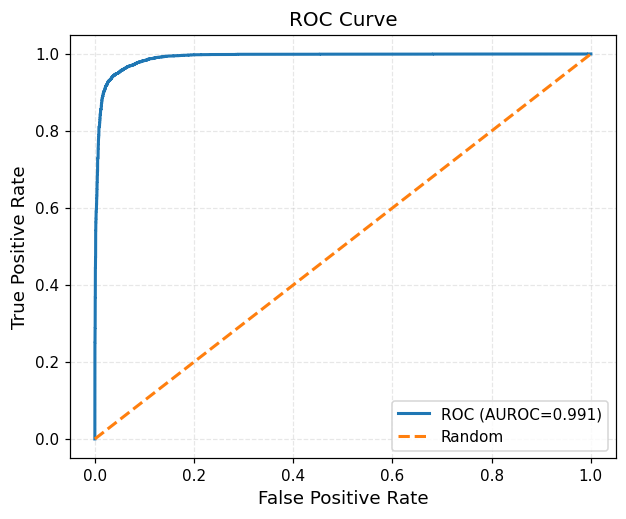

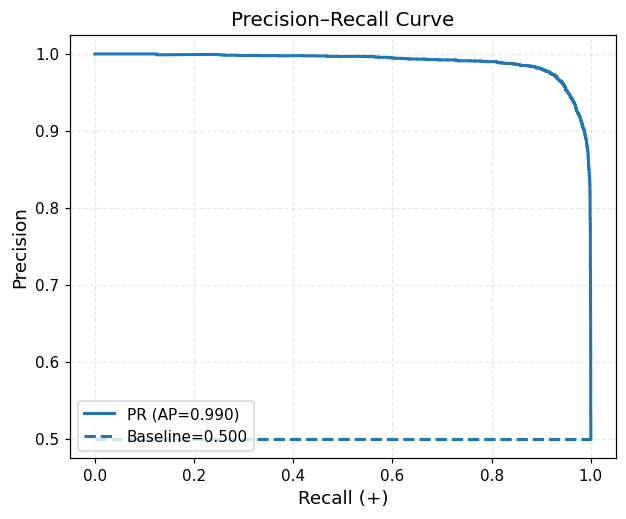

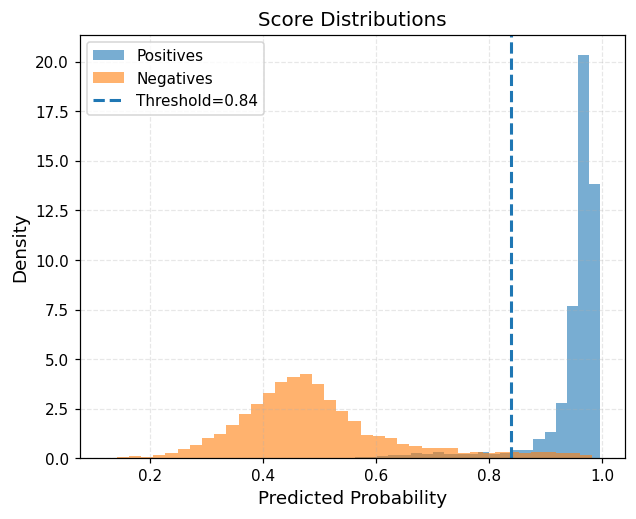

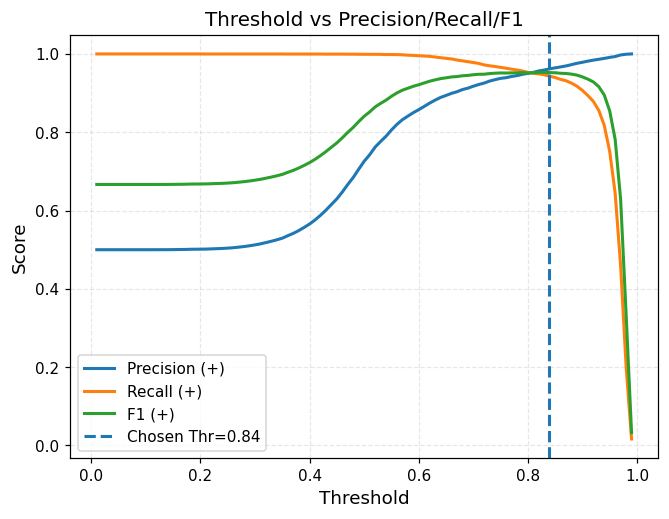

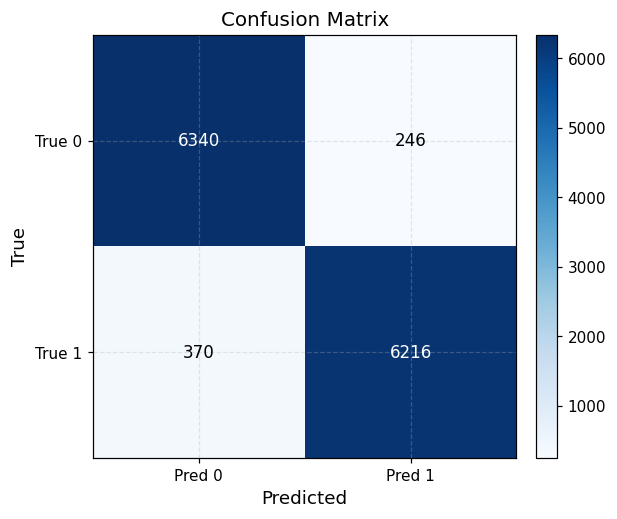

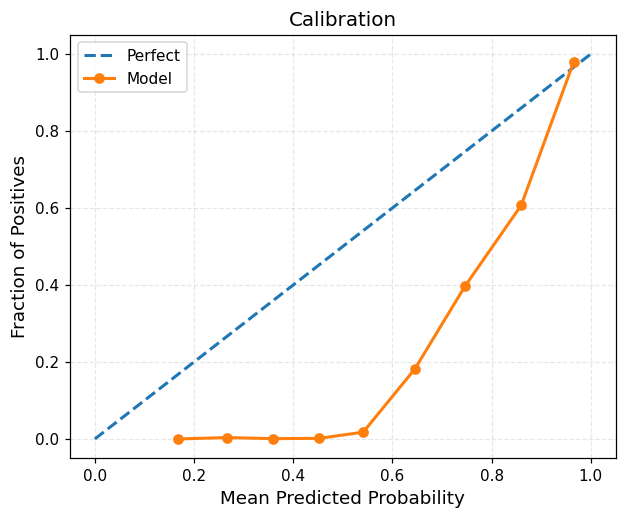


==== LINK PRED RESULTS ====
AUROC 0.9907 | AP 0.9901 | Thr 0.84
CM -> TN:6340 FP:246 FN:370 TP:6216
Class 0 (no-edge): {'precision': 0.9448584202682563, 'recall': 0.9626480412997267, 'f1': 0.95367027677497, 'support': 6586}
Class 1 (edge):    {'precision': 0.9619312906220984, 'recall': 0.9438202247191011, 'f1': 0.9527896995708155, 'support': 6586}
Overall: {'accuracy': 0.953234133009414, 'balanced_accuracy': 0.9532341330094138, 'macro_f1': 0.9532299881728927}
[PDF salvo] linkpred_report.pdf


In [9]:
out_link = run_link_prediction_with_plots(
    graph_path="graph.pkl",
    embeddings="embeddings.npy",
    pct_remove=0.2,
    seed=42,
    hidden=64, out_dim=64, epochs=1000, lr=1e-3,
    report_pdf_path="linkpred_report.pdf",
    optimize_threshold="youden",  # ou "f1" ou None
    show_plots=True
)


[NodeCls] Epoch 001 | Loss 1.0993 | TrainAcc 0.0894 | ValAcc 0.0883 | ValMacroF1 0.0541
[NodeCls] Epoch 010 | Loss 1.0465 | TrainAcc 0.4240 | ValAcc 0.4245 | ValMacroF1 0.3533
[NodeCls] Epoch 020 | Loss 0.9399 | TrainAcc 0.4436 | ValAcc 0.4480 | ValMacroF1 0.3737
[NodeCls] Epoch 030 | Loss 0.8522 | TrainAcc 0.5178 | ValAcc 0.5328 | ValMacroF1 0.4848
[NodeCls] Epoch 040 | Loss 0.7717 | TrainAcc 0.6056 | ValAcc 0.6204 | ValMacroF1 0.5844
[NodeCls] Epoch 050 | Loss 0.7158 | TrainAcc 0.6389 | ValAcc 0.6581 | ValMacroF1 0.6208
[NodeCls] Epoch 060 | Loss 0.6789 | TrainAcc 0.6546 | ValAcc 0.6660 | ValMacroF1 0.6257
[NodeCls] Epoch 070 | Loss 0.6508 | TrainAcc 0.6702 | ValAcc 0.6795 | ValMacroF1 0.6424
[NodeCls] Epoch 080 | Loss 0.6248 | TrainAcc 0.6880 | ValAcc 0.6973 | ValMacroF1 0.6611
[NodeCls] Epoch 090 | Loss 0.6022 | TrainAcc 0.7025 | ValAcc 0.7016 | ValMacroF1 0.6648
[NodeCls] Epoch 100 | Loss 0.5782 | TrainAcc 0.7096 | ValAcc 0.7101 | ValMacroF1 0.6737
[NodeCls] Epoch 110 | Loss 0.559

/tmp/ipython-input-3478771779.py:529: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fpr, tpr, _ = roc_curve(Yb[:, i], P_test[:, i]); roc_info[name] = (fpr, tpr, np.trapz(tpr, fpr))
/tmp/ipython-input-3478771779.py:531: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap_approx = np.trapz(pr_p[::-1], pr_r[::-1]); pr_info[name] = (pr_r, pr_p, ap_approx)
/tmp/ipython-input-3478771779.py:529: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fpr, tpr, _ = roc_curve(Yb[:, i], P_test[:, i]); roc_info[name] = (fpr, tpr, np.trapz(tpr, fpr))
/tmp/ipython-input-3478771779.py:531: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap_approx = np.t

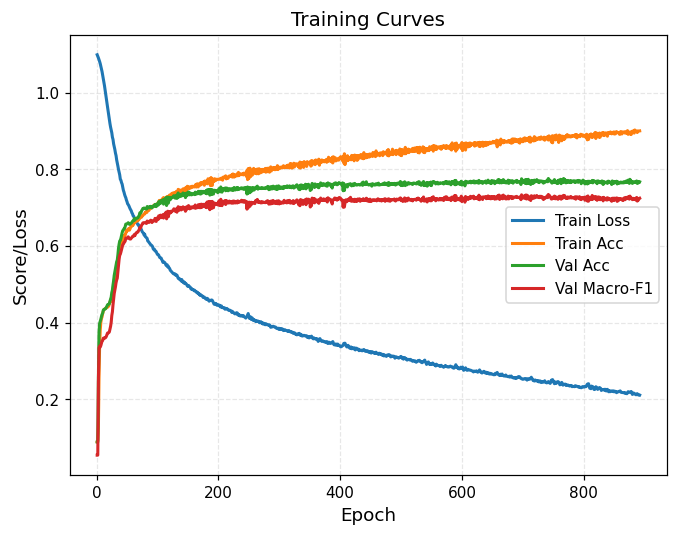

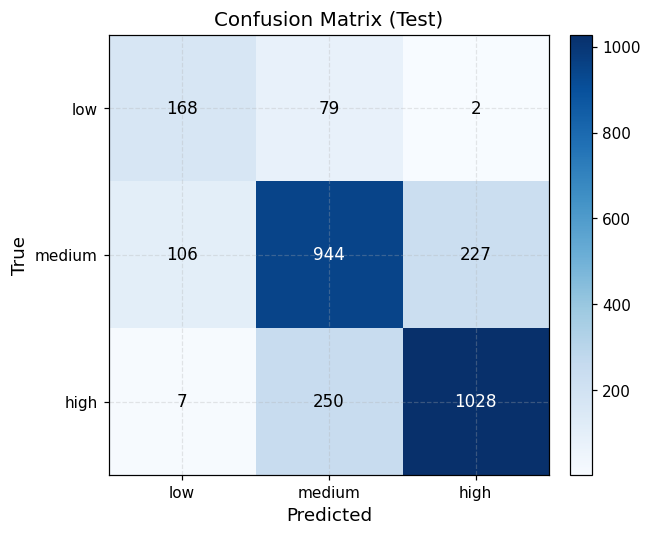

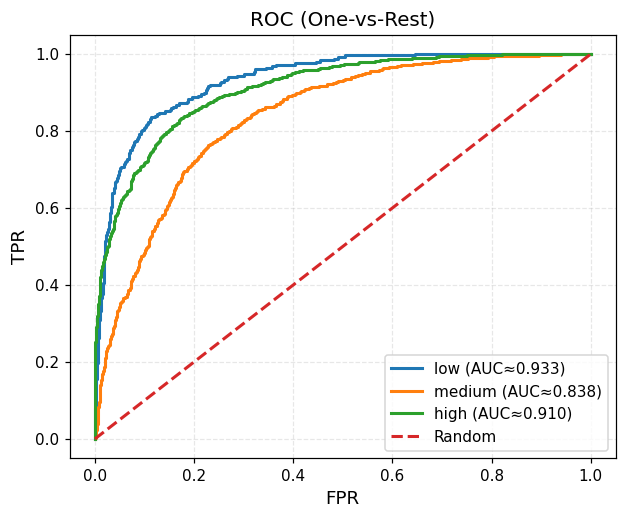

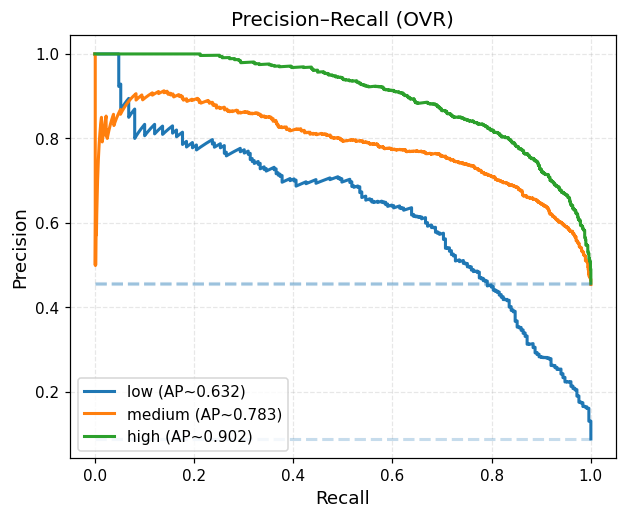

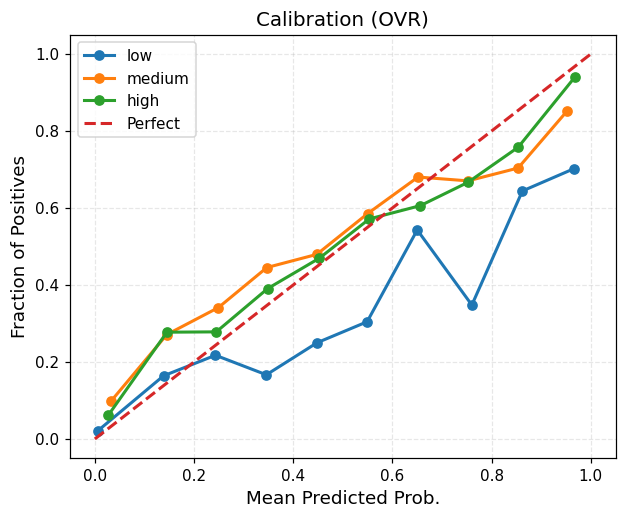


==== NODE CLS RESULTS ====
Overall: {'accuracy': 0.7612949128424048, 'balanced_accuracy': 0.7379771238438484, 'macro_f1': 0.7277221267003404}
Per class: {'low': {'precision': 0.597864768683274, 'recall': 0.6746987951807228, 'f1': 0.6339622641509434, 'support': 249}, 'medium': {'precision': 0.7415553809897879, 'recall': 0.7392325763508223, 'f1': 0.7403921568627451, 'support': 1277}, 'high': {'precision': 0.8178202068416865, 'recall': 0.8, 'f1': 0.8088119590873328, 'support': 1285}}
[PDF salvo] severity_nodecls_report.pdf


In [10]:

out_node = run_node_severity_eval(
    graph_path="graph.pkl",
    embeddings="embeddings.npy",
    labels_path="labels.npy",   # strings: 'low'/'medium'/'high'
    pct_test=0.2, pct_val=0.1,
    seed=42,
    hidden=64, out_dim_embed=64, dropout=0.2,
    epochs=1000, lr=1e-3, class_weight=True,
    report_pdf_path="severity_nodecls_report.pdf",
    show_plots=True,
    es_metric="val_macro_f1", es_patience=150
)